In [2]:
import numpy as np
import mnist

X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz") 
# print(X)
print(Y)


[5 0 4 ... 5 6 8]


In [3]:
#入力層のクラス
class InputLayer:
    def __init__(self, x):
        self.x = x
    def output(self):
        return self.x

In [4]:
# 畳み込み層のクラス
class ConvolutionLayer:
    def __init__(self, x, filter_mateix, bias, batch, R, s):
        self.x = x #batch * ch * dx * dy行列
        self.filter_matrix = filter_mateix #フィルター行列だが、R*Rではない。フィルター行列の集合
        self.bias = bias #バイアス
        self.batch = batch #バッチサイズ
        self.R = R #フィルターサイズ
        self.s = s #ストライド
    def padding(self):
        batch, ch, dx, dy = self.x.shape
        r = int(self.R/2)
        padding = np.zeros((batch, ch, dx + 2*r, dy + 2*r)) 
        padding[:, :, r:(dx+r), r:(dy+r)] = self.x
        return padding
    def rerange(self):
        batch, ch, dx, dy = self.x.shape
        C = self.padding()
        C = np.lib.stride_tricks.as_strided(C, shape=(batch, ch, int(dx/self.s), int(dy/self.s), self.R, self.R),\
                                            strides=(C.strides[0], C.strides[1],self.s*C.strides[2], self.s*C.strides[3], C.strides[2], C.strides[3])
                                           )
        C = C.transpose(1, 4, 5, 0, 2, 3).reshape(ch * self.R * self.R, -1)
        return C
    def output(self):
        W = self.filter_matrix
        B = self.bias
        return np.dot(W, self.rerange()) + B[:,np.newaxis]
    
# Convolutionレイヤの実装
class Convolution:
    
    # インスタンス変数の定義
    def __init__(self, W, b, stride=1, pad=1):
        self.W = W # フィルター(重み)
        self.b = b # バイアス
        self.stride = stride # ストライド
        self.pad = pad # パディング
        
        # (逆伝播時に使用する)中間データを初期化
        self.x = None # 入力データ
        self.col = None # 2次元配列に展開した入力データ
        self.col_W = None # 2次元配列に展開したフィルター(重み)
        
        # 勾配に関する変数を初期化
        self.dW = None # フィルター(重み)に関する勾配
        self.db = None # バイアスに関する勾配
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 各データに関するサイズを取得
        FN, C, FH, FW = self.W.shape # フィルター
        N, C, H, W = x.shape # 入力データ
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride) # 出力データ:式(7.1)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)
        
        # 各データを2次元配列に展開
        col = im2col(x, FH, FW, self.stride, self.pad) # 入力データ
        col_W = self.W.reshape(FN, -1).T # フィルター
        
        # 出力の計算:(図7-12)
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        # (逆伝播時に使用する)中間データを保存
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        # フィルターに関するサイズを取得
        FN, C, FH, FW = self.W.shape
        
        # 順伝播の入力を展開
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        # 各パラメータの勾配を計算:式(5.13)
        self.db = np.sum(dout, axis=0) # バイアス
        self.dW = np.dot(self.col.T, dout) # (展開した)重み
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW) # 本来の形状に変換
        dcol = np.dot(dout, self.col_W.T) # (展開した)入力データ
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad) # 本来の形状に変換

        return dx

In [5]:
# プーリング層のクラス
class PoolingLayer:
    def __init__(self, x, batch, R, s):
        self.x = x #畳み込み層からの入力
        self.batch = batch #バッチサイズ
        self.R = R #プーリング層のサイズ
        self.s = s #ストライド
        self.max_indices = None  # 最大値のインデックスを保持する変数
    def output(self):
        dx, dy = self.x.shape
        newdy = int(np.sqrt(int(dy/self.batch)))
        #これにより batch * K * dx * dy配列に変化
        tensor_x = np.array(np.array_split(self.x, dy // int(dy/self.batch), axis=1)).reshape(self.batch, dx, newdy, newdy)
        #これにpoolingを適用する
        d = self.R
        n, c, h, w = tensor_x.shape
        output_h = (h - d) // self.s + 1 #出力の高さ
        output_w = (w - d) // self.s + 1 #出力の幅
        pooled_data = tensor_x[:, :, :output_h * self.s, :output_w * self.s].reshape(n, c, output_h, d, output_w, d)
        pooled_data = pooled_data.max(axis=(3, 5))
        return pooled_data
    def max_index(self):
        dx, dy = self.x.shape
        newdy = int(np.sqrt(int(dy/self.batch)))
        #これにより batch * K * dx * dy配列に変化
        tensor_x = np.array(np.array_split(self.x, dy // int(dy/self.batch), axis=1)).reshape(self.batch, dx, newdy, newdy)
        #これにpoolingを適用する
        d = self.R
        n, c, h, w = tensor_x.shape
        output_h = (h - d) // self.s + 1 #出力の高さ
        output_w = (w - d) // self.s + 1 #出力の幅
        pooled_data = tensor_x[:, :, :output_h * self.s, :output_w * self.s].reshape(n, c, output_h, d, output_w, d)
        # マックスプーリングのマスクを作成、多分これで、インデックスを保持することができているはず、、、
        mask = (pooled_data == np.max(pooled_data, axis=(3, 5), keepdims=True))
        # mask = np.argwhere(pooled_data == np.max(pooled_data, axis=(3, 5)))
        mask = mask.reshape(n, c, output_h*d, output_w*d).astype(int)
        return mask
        
# プーリングレイヤの実装
class Pooling:
    
    # インスタンス変数の定義
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h # Poolingの高さ
        self.pool_w = pool_w # Poolingの横幅
        self.stride = stride # ストライド
        self.pad = pad # パディング
        
        # 逆伝播用の中間データ
        self.x = None # 入力データ
        self.arg_max = None # 最大値のインデックス
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 各データに関するサイズを取得
        N, C, H, W = x.shape # 入力サイズ
        out_h = int(1 + (H - self.pool_h) / self.stride) # 出力サイズ:式(7.1)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 入力データを2次元配列に展開
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        # 逆伝播用に最大値のインデックスを保存
        arg_max = np.argmax(col, axis=1)
        
        # 出力データを作成
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) # 4次元配列に再変換:(図7-20)
        
        # 逆伝播用に中間データを保存
        self.x = x # 入力データ
        self.arg_max = arg_max # 最大値のインデックス

        return out

    # 逆伝播メソッドの定義
    def backward(self, dout):
        # 入力データを変形:(図7-20の逆方法)
        dout = dout.transpose(0, 2, 3, 1)
        
        # 受け皿を作成
        pool_size = self.pool_h * self.pool_w # Pooling適用領域の要素数
        dmax = np.zeros((dout.size, pool_size)) # 初期化
        
        # 最大値の要素のみ伝播
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        
        # 4次元配列に変換
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [6]:
#行列の変換を行うだけのクラス
class Reshape:
    def __init__(self, x, batch):
        self.x = x
        self.batch = batch
    def reshape(self):
        dx, dy = self.x.shape
        newdy = int(np.sqrt(int(dy/self.batch)))
        tensor = np.array(np.array_split(self.x, dy // int(dy/self.batch), axis=1)).reshape(self.batch, dx, newdy, newdy)
        return tensor

In [7]:
#4次元対応の全結合のクラス
class Affine:
    
    # インスタンス変数の定義
    def __init__(self, W, b):
        self.W = W # 重み
        self.b = b # バイアス
        self.x = None # 入力データ
        self.original_x_shape = None # 入力データのサイズ
        self.dW = None # 重みに関する勾配
        self.db = None # バイアスに関する勾配
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 入力データのサイズを保存
        self.original_x_shape = x.shape
        
        # バッチサイズ行の2次元配列に変形
        x = x.reshape(x.shape[0], -1)
        self.x = x
        
        # 重み付きバイアスの和の計算
        out = np.dot(self.x, self.W) + self.b

        return out
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        # 勾配を計算
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        # 入力データのサイズに変形
        dx = dx.reshape(*self.original_x_shape)
        return dx

In [8]:
# 全結合層1のクラス
class Connection1Layer:
    def __init__(self, x, w1, b1):
        self.x = x
        self.w1 = w1
        self.b1 = b1
    def output(self):
        self.x = np.array(self.x)
        self.w1 = np.array(self.w1)
        self.b1 = np.array(self.b1)
        return np.dot(self.w1.T, self.x) + self.b1[:, np.newaxis]
    def dot_w1x(self):
        self.x = np.array(self.x)
        self.w1 = np.array(self.w1)
        return np.dot(self.w1.T, self.x)
    def dot_b1(self):
        self.b1 = np.array(self.b1)
        return self.b1[:, np.newaxis]
    def test_output(self):
        self.x = np.array(self.x)
        self.w1 = np.array(self.w1)
        self.b1 = np.array(self.b1)
        return np.dot(self.w1.T, self.x) + self.b1

In [9]:
#中間層のクラス(sigmoid, relu)
class MiddleLayer:
    def __init__(self, x, function):
        self.x = x
        self.function = function
    def output(self):
        return self.function(self.x)
    
# 中間層のクラス（dropout）
class Dropout:
    def __init__(self, x, rho):
        self.x = x
        self.rho = rho
    def output(self):
        rows, cols = self.x.shape
        indices = np.arange(rows)
        np.random.shuffle(indices)
        result_matrix = np.copy(self.x)
        for col in range(cols):
            selected_indices = indices[:self.rho]
            result_matrix[selected_indices, col] = 0
        return result_matrix

In [10]:
# 全結合層2のクラス
class Connection2Layer:
    def __init__(self, x, w2, b2):
        self.x = x
        self.w2 = w2
        self.b2 = b2
    def output(self):
        self.x = np.array(self.x)
        self.w2 = np.array(self.w2)
        self.b2 = np.array(self.b2)
        return np.dot(self.w2.T, self.x) + self.b2[:, np.newaxis]
    def test_output(self):
        self.x = np.array(self.x)
        self.w2 = np.array(self.w2)
        self.b2 = np.array(self.b2)
        return np.dot(self.w2.T, self.x) + self.b2

In [11]:
# 出力層のクラス
class OutputLayer:
    def __init__(self, x, softmax):
        self.x = x
        self.softmax = softmax
    def output(self):
        return self.softmax(self.x)

In [12]:
# クロスエントロピーを計算するクラス
class CrossEntropy:
    def __init__(self, x, onehot):
        self.x = x
        self.onehot = onehot
    def safelog(self):
        try:
            result = -np.log(self.x)
        except RuntimeWarning as e:
            result = np.where(self.x <= 0, 100, -np.log(self.x))
        return result
    def result(self):
        loglist = self.safelog()
        crossentropy = np.sum(self.onehot * loglist, axis=0)
        batch = loglist.shape[1]
        return np.sum(crossentropy) / batch

In [13]:
# softmaxとクロスエントロピー誤差の逆伝播クラス
class ErrorBackCrossEntropy:
    def __init__(self, x, onehot):
        self.x = x
        self.onehot = onehot
    def del_en_x(self):
        batch = self.x.shape[1]
        return (self.x - self.onehot) / batch

In [14]:
# 全結合層2の逆伝播のクラス
class ErrorBackConnect2:
    def __init__(self, x, del_en_y, w2):
        self.x = x
        self.del_en_y = del_en_y
        self.w2 = w2
    def del_en_x(self):
        return np.dot(self.w2, self.del_en_y)
    def del_en_w2(self):
        # print(self.w2.shape)
        return np.dot(self.del_en_y, self.x.T)
    def del_en_b2(self):
        return np.sum(self.del_en_y, axis=1)

In [15]:
# 中間層の逆伝播のクラス
# シグモイド関数の逆伝播のクラス
class ErrorBackSigmoid:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = (1 - self.y) * self.y
        result = self.del_en_y * new_y
        return result
    
# relu関数の逆伝播のクラス
class ErrorBackReLU:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = np.where(self.y > 0, 1, 0)
        result = self.del_en_y * new_y
        return result
    
# dropoutの逆伝播クラス
class ErrorBackDropout:
    def __init__(self, y, del_en_y):
        self.y = y
        self.del_en_y = del_en_y
    def del_en_x(self):
        new_y = np.where(self.y == 0, 0, 1)
        result = self.del_en_y * new_y
        return result

In [16]:
#正規化層の誤差逆伝播クラス
class ErrorBackNormalize:
    def __init__(self, x, x_hat, del_en_y, gamma, beta, epsilon, mean, var, batch):
        self.x = x
        self.x_hat = x_hat
        self.del_en_y = del_en_y
        self.gamma = gamma
        self.beta = beta
        self.epsilon = epsilon
        self.mean = mean
        self.var = var
        self.batch = batch
    def del_en_x_hat(self):
        return self.del_en_y * self.gamma[:,np.newaxis]
    def del_en_var(self):
        mult = np.sum(self.del_en_x_hat()*(self.x - self.mean[:, np.newaxis]), axis=1)
        return (-1) / 2 * mult *  np.power((self.var + self.epsilon), -1.5 ) 
    def del_en_mean(self):
        e1 = np.sum(self.del_en_x_hat(), axis=1)  * (-1) / np.sqrt(self.var + self.epsilon)
        e2 = (-2) * self.del_en_var() * (np.sum(self.x, axis=1)/self.batch - self.mean)
        return e1 + e2
    def del_en_x(self):
        e1 = self.del_en_x_hat() / np.sqrt(self.var + self.epsilon)[:,np.newaxis]
        e2 = 2 / self.batch * (self.x - self.mean[:,np.newaxis]) * self.del_en_var()[:,np.newaxis]
        e3 = self.del_en_mean() / self.batch
        return e1 + e2 + e3[:,np.newaxis]
    def del_en_gamma(self):
        return np.sum(self.del_en_y * self.x, axis=1)
    def del_en_beta(self):
        return np.sum(self.del_en_y, axis=1)

In [17]:
# 全結合層1の逆伝播クラス
class ErrorBackConnect1:
    def __init__(self, x, del_en_y, w1):
        self.x = x
        self.del_en_y = del_en_y
        self.w1 = w1
    def del_en_x(self):
        return np.dot(self.w1, self.del_en_y)
    def del_en_w1(self):
        return np.dot(self.del_en_y, self.x.T)
    def del_en_b1(self):
        return np.sum(self.del_en_y, axis=1)

In [18]:
# プーリング層の誤差逆伝播クラス
class ErrorBackPooling:
    def __init__(self, x, y, del_en_y, K, batch, max_index, R, R_conv):
        self.x = x #プーリング層の入力
        self.y = y #プーリング層の出力
        self.del_en_y = del_en_y
        self.K = K #フィルタ数
        self.batch = batch
        self.max_index = max_index #プーリング層で抽出された要素は1, そうでない要素は0となっている配列
        self.R = R #プーリングのサイズ
        self.R_conv = R_conv
    def reshape_del(self, m):
        self.m = m
        z, batch = self.m.shape
        dx = int(np.sqrt(int(z/self.K)))
        #これにより、batch*K*dx*dx配列に変化
        tensor_del = self.m.T.reshape(batch, self.K, dx, dx)
        return tensor_del
    def reshape_x(self, n):
        self.n = n
        dx, dy = self.n.shape
        newdy = int(np.sqrt(int(dy/self.batch)))
        #これにより batch * K * dx * dy配列に変化
        tensor_x = np.array(np.array_split(self.n, dy // int(dy/self.batch), axis=1)).reshape(self.batch, dx, newdy, newdy)
        #これにpoolingを適用する
        return tensor_x
    #こちらは、pooling層2の誤差逆伝播に限定することにする
    def del_en_x(self):
        del_en_y_reshaped = self.reshape_del(self.del_en_y)
        b, k, dx, dy =  self.reshape_x(self.x).shape
        expanded_del = del_en_y_reshaped.repeat(self.R, axis=2).repeat(self.R, axis=3)
        expanded_del = expanded_del.reshape(b, k, dx, dy)
        C = expanded_del * self.max_index
        return C.transpose(1, 0, 2, 3).reshape(k, -1)
    #こちらはpooling層1の誤差逆伝播に限定
    def del_en_x_sub(self):
        # b, k, dx, dy = self.y.shape
        b, k, h, w = self.reshape_x(self.x).shape
        # expanded_del = self.del_en_y[np.arange(self.del_en_y.shape[0]) % 9 == 4]
        # expanded_del = self.reshape_del(expanded_del)
        # expanded_del = expanded_del.repeat(self.R, axis=2).repeat(self.R, axis=3)
        # expanded_del = expanded_del.reshape(b, k, w, h)
        # dx, dy = self.x.shape
        expanded_del = col2im(self.del_en_y, self.y.shape, 3, 3, 1, 1)
        expanded_del = expanded_del.repeat(self.R, axis=2).repeat(self.R, axis=3)
        expanded_del = expanded_del.reshape(b, k, w, h)
        
        C = expanded_del * self.max_index
        return C.transpose(1, 0, 2, 3).reshape(k, -1)

In [19]:
# 畳み込み層の誤差逆伝播クラス
class ErrorBackConvolution:
    def __init__(self, x, del_en_y, w):
        self.x = x
        self.del_en_y = del_en_y
        self.w = w
    def del_en_x(self):
        return np.dot(self.w.T, self.del_en_y)
    def del_en_w(self):
        return np.dot(self.del_en_y, self.x.T)
    def del_en_b(self):
        return np.sum(self.del_en_y, axis=1)
    def del_en_x_sub(self):
        del_y = np.dot(self.w.T, self.del_en_y)
        expanded_del = del_y[np.arange(del_y.shape[0]) % 9 == 4]
        return expanded_del

0~9999の整数を入力してください: 12


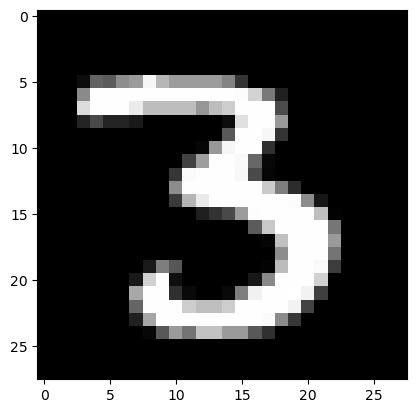

正解は:3
予測結果は:9
[[ 0.06300187  0.01429133  0.03495493 ...  0.02776751 -0.05763921
  -0.00759787]
 [-0.03198095  0.01381795 -0.01824304 ...  0.06378109  0.00453257
   0.01435676]
 [ 0.06725538 -0.04813425 -0.04537446 ...  0.03989344 -0.04699669
  -0.01648516]
 ...
 [-0.02571133  0.02809776  0.10875591 ... -0.03597355  0.03074085
   0.01763069]
 [ 0.02699757 -0.03636457 -0.00686967 ... -0.00920771 -0.00089243
   0.02344971]
 [ 0.00097252 -0.03004448  0.00856151 ... -0.06824825  0.07191712
   0.02005035]]


In [20]:
# kadai1
import matplotlib.pyplot as plt
from pylab import cm

# シード値を固定する
np.random.seed(0)
# 画像サイズ
picture_size = 28 * 28
# 中間層の数
M = 50 
# 標準入力
i = int(input("0~9999の整数を入力してください:"))
# クラス数
C =10

# 784次元ベクトル
test_data = X[i].reshape(picture_size)

# 　d×M行列W1
W_1 = np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M))
# M次元ベクトルb1
b_1 = np.random.normal(0, 1/np.sqrt(picture_size), M)
# 中間層前の計算結果
dot_1 = np.dot(np.array(W_1).T, test_data) + b_1

y_1 = 1 / (1 + np.exp(-dot_1))

# C ×M行列W2
W_2 = np.random.normal(0, 1/np.sqrt(picture_size), (M, C))
# C次元ベクトルb2
b_2 = np.random.normal(0, 1/np.sqrt(picture_size), C)
# 出力層前の計算結果
dot_2 = np.dot(np.array(W_2).T, y_1) + b_2

#dot_2のうち、最大の要素
alpha = np.max(dot_2)

# ソフトマックス関数を適用した後のベクトル
softmax_vector = np.exp(dot_2 - alpha) / np.sum(np.exp(dot_2 - alpha))

# 結果
result = np.argmax(softmax_vector)

plt.imshow(X[i], cmap=cm.gray)
plt.show()
print("正解は:"+str(Y[i]))

print("予測結果は:"+str(result))

# print(W_2)
print(W_1)

In [21]:
# 関数集1

# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ソフトマックス関数
def softmax(x):
    x = x - np.max(x, axis = 0)
    return np.exp(np.array(x)) / np.sum(np.exp(np.array(x)), axis=0)

# リストの一致率を示す関数
def calculate_similarity(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("リストの長さが異なります")

    # 一致した要素の数を数える
    match_count = sum(1 for a, b in zip(list1, list2) if a == b)

    # 一致率を計算
    similarity = (match_count / len(list1)) * 100  # パーセントで表示

    return similarity


# ReLU関数
def relu(x):
    return np.where(x > 0, x, 0)


#畳み込み層の誤差逆伝播において、二次元配列を4次元配列に変換する関数
# 出力データの再変換関数の定義
def col2im(col, input_shape, filter_h, filter_w, stride, pad):
    
    # 入力データのサイズを取得
    N, C, H, W = input_shape
    
    # 出力データのサイズを計算
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    
    # データとチャンネルに関する軸を分割
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    
    # 出力データの受け皿を初期化
    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    
    # 行方向のインデックス
    for y in range(filter_h):
        # 行方向の最大値を計算
        y_max = y + stride * out_h
        
        # 列方向のインデックス
        for x in range(filter_w):
            # 列方向の最大値を計算
            x_max = x + stride * out_w
            
            # フィルターのy,x要素に対応する入力データの要素を抽出
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


# 入力データの展開関数を定義
def im2col(input_data, filter_h, filter_w, stride, pad):
    
    # 入力データのサイズを取得
    N, C, H, W = input_data.shape
    
    # 出力データのサイズを計算
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    
    # パディング
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    
    # 出力データの受け皿を初期化
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    # 行方向のインデックス
    for y in range(filter_h):
        # 行方向の最大値を計算
        y_max = y + stride * out_h
        
        # 列方向のインデックス
        for x in range(filter_w):
            # 列方向の最大値を計算
            x_max = x + stride * out_w
            
            # フィルターのy,x要素に対応する入力データの要素を抽出
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # 出力サイズに整形
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

In [35]:
# 課題3を上記のクラスを用いてやってみる。うまくいったら、課題4以降はこれでやっていく。
#普通の3NN
# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(151)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))

def sigmoid_nn(batch, W_1, b_1, W_2, b_2):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
#     学習率
    eta = 0.1

#     0~59999までを重複なく取得
    sampled_data =  np.random.choice(60000, size=(int(60000/batch), batch), replace=False)
    i = len(sampled_data)-1
#      1epoch分
    mean_cross_entropy = 0
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層
        middle_layer = MiddleLayer(connection1_layer.output(), sigmoid)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.del_en_x(), w2_matrix)
        # print(errorback_connect2.del_en_b2())
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackSigmoid(middle_layer.output(), errorback_connect2.del_en_x())
#     全結合層1の誤差伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_sigmoid.del_en_x(), w1_matrix)
        # print(errorback_connect1.del_en_b1())
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
        
sigmoid_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector)
j = 10
while(j > 1):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    sigmoid_nn(100, w1, b1, w2, b2)
    j -= 1
    print("epoch残り"+str(j))

平均のクロスエントロピー1.3828268052892005
正解率:85.0
平均のクロスエントロピー0.5098798113738282
正解率:90.0
epoch残り9
平均のクロスエントロピー0.3829448198274774
正解率:91.0
epoch残り8
平均のクロスエントロピー0.33327546933295643
正解率:90.0
epoch残り7
平均のクロスエントロピー0.3047152359693335
正解率:93.0
epoch残り6
平均のクロスエントロピー0.28392983690744783
正解率:88.0
epoch残り5
平均のクロスエントロピー0.26734645509086385
正解率:88.0
epoch残り4
平均のクロスエントロピー0.25305299254962094
正解率:93.0
epoch残り3
平均のクロスエントロピー0.24065932344463425
正解率:94.0
epoch残り2
平均のクロスエントロピー0.23017427002706217
正解率:92.0
epoch残り1


In [36]:
# kadai4-1 ReLUの実装

# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(100)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))

def relu_nn(batch, W_1, b_1, W_2, b_2):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
#     学習率
    eta = 0.1

#     0~59999までを重複なく取得
    sampled_data =  np.random.choice(60000, size=(int(60000/batch), batch), replace=False)
    i = len(sampled_data)-1
#      1epoch分
    mean_cross_entropy = 0
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層 ReLU
        middle_layer = MiddleLayer(connection1_layer.output(), relu)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.del_en_x(), w2_matrix)
#     中間層の誤差逆伝播relu
        errorback_relu = ErrorBackReLU(middle_layer.output(), errorback_connect2.del_en_x())
#     全結合層1の誤差伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_relu.del_en_x(), w1_matrix)
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
        
relu_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector)
j = 0
while(j < 10):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    relu_nn(100, w1, b1, w2, b2)
    j += 1
    print("epoch"+str(j))

平均のクロスエントロピー0.6082035554270542
正解率:93.0
平均のクロスエントロピー0.2925350276670146
正解率:98.0
epoch1
平均のクロスエントロピー0.242333018989007
正解率:88.0
epoch2
平均のクロスエントロピー0.20817543175314432
正解率:89.0
epoch3
平均のクロスエントロピー0.18203498524140926
正解率:97.0
epoch4
平均のクロスエントロピー0.1623692319244151
正解率:96.0
epoch5
平均のクロスエントロピー0.14607267210956393
正解率:93.0
epoch6
平均のクロスエントロピー0.13350422904894027
正解率:97.0
epoch7
平均のクロスエントロピー0.12239789521677402
正解率:94.0
epoch8
平均のクロスエントロピー0.11347383207813803
正解率:92.0
epoch9
平均のクロスエントロピー0.10557980700337004
正解率:97.0
epoch10


In [38]:
# kadai4-2 dropout
# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(99)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))

def dropout_nn(batch, W_1, b_1, W_2, b_2):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
#     学習率
    eta = 0.1
#     無視するノードの割合
    rho = 0.1
#     0~53999までを重複なく取得
    sampled_data =  np.random.choice(54000, size=(int(54000/batch), batch), replace=False)
    i = len(sampled_data)-1
    #      1epoch分
    mean_cross_entropy = 0
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層、dropout
        random_num = int(rho * M)
        dropout = Dropout(connection1_layer.output(), random_num)
#     全結合層2
        connection2_layer = Connection2Layer(dropout.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(dropout.output(), errorback_crossentropy.del_en_x(), w2_matrix)
#     dropout中間層の誤差逆伝播
        errorback_dropout = ErrorBackDropout(dropout.output(),errorback_connect2.del_en_x())
#     全結合層1の誤差伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_dropout.del_en_x(), w1_matrix)
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X[54000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(picture_size)
                test_vectors.append(y)
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y[54000:]
    #      入力層
            input_layer = InputLayer(test_vectors)
    #      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
    #     中間層、dropout、1-rho倍
            middle_output = (1 - rho) * connection1_layer.output()
    #     全結合層2
            connection2_layer = Connection2Layer(middle_output, w2_matrix, b2_vector)
    #     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
            
            
        
# dropout_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector)
j = 10
while(j > 0):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    dropout_nn(100, w1, b1, w2, b2)
    j -= 1
    print("epoch"+str(j))
#     if (j==0):
#         k = int(input("0~60000から数字を入力"))
#         x_data = X[k].reshape(picture_size)
# #      入力層
#         input_layer = InputLayer(x_data)
# #      全結合層1
#         connection1_layer = Connection1Layer(input_layer.output(), w1, b1)
# #     中間層、dropout
#         rho = 0.1
#         middle_output = (1 - rho) * connection1_layer.test_output()
# #     全結合層2
#         connection2_layer = Connection2Layer(middle_output, w2, b2)
# #     出力層
#         output_layer = OutputLayer(connection2_layer.test_output(), softmax)
# #      結果
#         result = np.argmax(output_layer.output())
#         plt.imshow(X[k], cmap=cm.gray)
#         plt.show()
#         print("正解は:"+str(Y[k]))
#         print("予測結果は:"+str(result))
# #         出力をベクトルにしたいのに、行列になってる
# #         print(connection1_layer.dot_b1())
        

平均のクロスエントロピー0.5535353182943528
正解率:92.0
テスト開始
テスト正解率:92.56666666666666
epoch9
平均のクロスエントロピー0.5241047314094931
正解率:88.0
テスト開始
テスト正解率:92.95
epoch8
平均のクロスエントロピー0.48773654409572603
正解率:83.0
テスト開始
テスト正解率:91.8
epoch7
平均のクロスエントロピー0.48613580718421223
正解率:88.0
テスト開始
テスト正解率:93.38333333333333
epoch6
平均のクロスエントロピー0.45074703182889225
正解率:88.0
テスト開始
テスト正解率:93.21666666666667
epoch5
平均のクロスエントロピー0.43691255580857696
正解率:90.0
テスト開始
テスト正解率:93.83333333333333
epoch4
平均のクロスエントロピー0.4268496343942722
正解率:90.0
テスト開始
テスト正解率:93.61666666666667
epoch3
平均のクロスエントロピー0.41931929977799565
正解率:90.0
テスト開始
テスト正解率:93.5
epoch2
平均のクロスエントロピー0.4165832578792513
正解率:89.0
テスト開始
テスト正解率:93.16666666666666
epoch1
平均のクロスエントロピー0.40589882629516105
正解率:95.0
テスト開始
テスト正解率:93.55
epoch0


In [1]:
# kadai4-3（バッチ正規化）
# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(115)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))
#     正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)

def batchnorm_nn(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
#     学習率
    eta = 0.1
#     イプシロンの値
    epsilon = 0.001

#     0~53999までを重複なく取得
    sampled_data =  np.random.choice(50000, size=(int(50000/batch), batch), replace=False)
    i = len(sampled_data)-1
    #      1epoch分
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層に入力させる前に正規化処理を行う
#     各行ごとに平均をとるμ
#         50次元ベクトル
        row_means = np.mean(connection1_layer.output(), axis=1)
#         print(row_means)
        mean_mean += row_means
#     各行ごとに分散をとる σ
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#         print(x_hat.shape)
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     中間層は一旦シグモイド関数で試してみる
        middle_layer = MiddleLayer(normalized_matrix, relu)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)    
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.del_en_x(), w2_matrix)
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackReLU(middle_layer.output(), errorback_connect2.del_en_x())
#     正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_sigmoid.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
#         print(errorback_normalize.del_en_x())
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_normalize.del_en_x(), w1_matrix)
#     変数の更新
#         print(errorback_connect1.del_en_w1().T)
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta", beta)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X[50000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(picture_size)
                test_vectors.append(y)
    #         正規化
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y[50000:]
    #      入力層
            input_layer = InputLayer(test_vectors)
    #      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#         正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
            # print(normalized_output.shape)
#         中間層
            middle_layer = MiddleLayer(normalized_output, relu)
    #     全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
    #     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
batchnorm_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector, gamma, beta)
j = 10
while(j > 0):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma.npy')
    beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta.npy')
    batchnorm_nn(100, w1, b1, w2, b2, gamma, beta)
    j -= 1
    print("epoch"+str(j))

NameError: name 'np' is not defined

In [24]:
# kadai4-4　慣性項つきSGD 中身はシグモイド、バッチ正規化ありで行う。他も気が向いたらやってみよう
# まず、シード値を固定した状態でランダムにパラメータを設定する
np.random.seed(64)
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (picture_size, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))
#     正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)

def batchnorm_nn(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init):
#     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
    delta_W1 = np.zeros((picture_size, M))
    delta_W2 = np.zeros((M, C))
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
#     慣性項
    alpha = 0.9
#     学習率
    eta = 0.1
#     イプシロンの値
    epsilon = 0.001

#     0~53999までを重複なく取得
    sampled_data =  np.random.choice(50000, size=(int(50000/batch), batch), replace=False)
    i = len(sampled_data)-1
    #      1epoch分
    
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(picture_size)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層に入力させる前に正規化処理を行う
#     各行ごとに平均をとるμ
#         50次元ベクトル
        row_means = np.mean(connection1_layer.output(), axis=1)
#         print(row_means)
        mean_mean += row_means
#     各行ごとに分散をとる σ
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#         print(x_hat.shape)
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     中間層は一旦シグモイド関数で試してみる
        middle_layer = MiddleLayer(normalized_matrix, sigmoid)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)    
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.del_en_x(), w2_matrix)
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackSigmoid(middle_layer.output(), errorback_connect2.del_en_x())
#     正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_sigmoid.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
#         print(errorback_normalize.del_en_x())
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_normalize.del_en_x(), w1_matrix)
#     変数の更新
#         print(errorback_connect1.del_en_w1().T)
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T + alpha * delta_W1
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T + alpha * delta_W2
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        delta_W1 = alpha * delta_W1 - eta * errorback_connect1.del_en_w1().T 
        delta_W2 = alpha * delta_W2 - eta * errorback_connect2.del_en_w2().T
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        # print(f'{crossentropy.result()}')
        if(i==0):
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/test_mean", test_mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/test_var", test_var)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X[50000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(picture_size)
                test_vectors.append(y)
    #         正規化
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y[50000:]
    #      入力層
            input_layer = InputLayer(test_vectors)
    #      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#         正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
            # print(normalized_output.shape)
#         中間層
            middle_layer = MiddleLayer(normalized_output, sigmoid)
    #     全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
    #     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
batchnorm_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector, gamma, beta)
j = 10
while(j > 0):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/b2.npy')
    gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/gamma.npy')
    beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/mnist_contest_noconv/beta.npy')
    batchnorm_nn(100, w1, b1, w2, b2, gamma, beta)
    j -= 1
    print("epoch"+str(j))

平均のクロスエントロピー0.49378663630164266
正解率:95.0
テスト開始
テスト正解率:90.31
平均のクロスエントロピー0.2965866604769043
正解率:87.0
テスト開始
テスト正解率:92.85
epoch9
平均のクロスエントロピー0.25998025301029376
正解率:94.0
テスト開始
テスト正解率:93.11
epoch8
平均のクロスエントロピー0.23291867933984567
正解率:91.0
テスト開始
テスト正解率:93.71000000000001
epoch7
平均のクロスエントロピー0.20808405667340982
正解率:98.0
テスト開始
テスト正解率:94.14
epoch6
平均のクロスエントロピー0.18777352497713923
正解率:98.0
テスト開始
テスト正解率:94.26
epoch5
平均のクロスエントロピー0.16932237331241123
正解率:95.0
テスト開始
テスト正解率:94.51
epoch4
平均のクロスエントロピー0.15560356421181587
正解率:96.0
テスト開始
テスト正解率:95.5
epoch3
平均のクロスエントロピー0.14108456600121932
正解率:97.0
テスト開始
テスト正解率:95.78
epoch2
平均のクロスエントロピー0.12915910658622307
正解率:90.0
テスト開始
テスト正解率:95.69
epoch1
平均のクロスエントロピー0.11833289832753972
正解率:100.0
テスト開始
テスト正解率:95.72
epoch0


テスト開始します


0~60000の整数を入力してください 9191


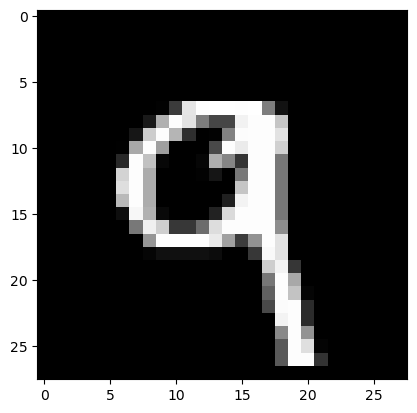

正解は:9
予測結果は:9


In [54]:
# kadai5
# 学習モデルは3NN、バッチ正規化を全結合層1と中間層の間で行う。
# 中間層の活性化関数にはシグモイド関数を用いる
# また、学習時のパラメータ更新方法は慣性項つきSGDを採用している
def mnist_recog(w1, b1, w2, b2, gamma, beta, test_mean, test_var):
    #     イプシロンの値
    epsilon = 0.001
    i = int(input("0~60000の整数を入力してください"))
    # 784次元ベクトル
    test_data = X[i].reshape(picture_size)
#     入力層
    input_layer = InputLayer(test_data)
#     全結合層1
    connection1_layer = Connection1Layer(input_layer.output(), w1, b1)
#     正規化
    e1 = (gamma / np.sqrt(test_var + epsilon)) * connection1_layer.test_output()
    e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
    normalized_output = e1 + e2
#   中間層
    middle_layer = MiddleLayer(normalized_output, sigmoid)
#     全結合層2
    connection2_layer = Connection2Layer(middle_layer.output(), w2, b2)
#     出力層
    output_layer = OutputLayer(connection2_layer.test_output(), softmax)
    result = np.argmax(output_layer.output())
    plt.imshow(X[i], cmap=cm.gray)
    plt.show()
    print("正解は:"+str(Y[i]))

    print("予測結果は:"+str(result))

w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma.npy')
beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta.npy')
test_mean = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_mean.npy')
test_var = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_var.npy')
print("テスト開始します")
mnist_recog(w1, b1, w2, b2, gamma, beta, test_mean, test_var)

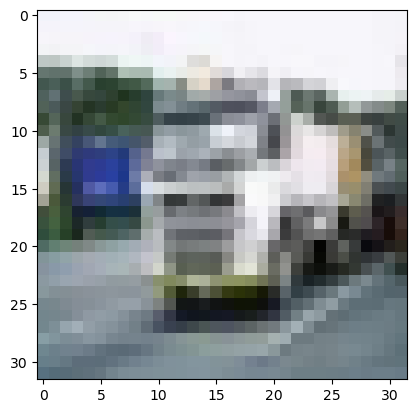

Y_color[idx]=9
60000


In [45]:
# advanced task A - 1 color picture
import numpy as np
import pickle
# import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    X = np.array(dict[b'data'])
    X = X.reshape((X.shape[0],3,32,32))
    Y = np.array(dict[b'labels'])
    return X,Y

x_1,y_1 = unpickle("./cifar-10-batches-py/data_batch_1")
x_2, y_2 = unpickle("./cifar-10-batches-py/data_batch_2")
x_3, y_3 = unpickle("./cifar-10-batches-py/data_batch_3")
x_4, y_4 = unpickle("./cifar-10-batches-py/data_batch_4")
x_5, y_5 = unpickle("./cifar-10-batches-py/data_batch_5")
x_test, y_test = unpickle("./cifar-10-batches-py/test_batch")

X_color = np.concatenate((x_1, x_2, x_3, x_4, x_5, x_test))
Y_color = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_test))


idx = 1000
plt.imshow(X_color[idx].transpose((1,2,0)))
plt.show()
print(f'{Y_color[idx]=}')
# print(X[idx])
print(len(X_color))

In [47]:
#color picture learning
# シード値を固定する
np.random.seed(923)

# 画像サイズ
d = 3 * 32 * 32
# 中間層の数
M = 50 
# クラス数
C = 10

# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (d, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), M))
# C(0~9) ×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(picture_size), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(picture_size), C))
#正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)

def color_recognition_nn(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init):
    #     変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
    delta_W1 = np.zeros((d, M))
    delta_W2 = np.zeros((M, C))
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    #慣性項
    alpha = 0.9
    #学習率
    eta = 0.1
    #イプシロンの値
    epsilon = 0.001
    #0~53999までを重複なく取得
    sampled_data =  np.random.choice(54000, size=(int(54000/batch), batch), replace=False)
    i = len(sampled_data)-1
#     ここから回す
    while(i > 0):
        batch_index = sampled_data[i]
        batches = X_color[batch_index]
        batch_vectors = []
        for x in batches:
            y = x.reshape(d)
            batch_vectors.append(y)
        batch_vectors = np.array(batch_vectors).T / 255
#     正解データ
        correct_labels = Y_color[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#      入力層
        input_layer = InputLayer(batch_vectors)
#      全結合層1
        connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#     中間層に入力させる前に正規化処理を行う
#     各行ごとに平均をとるμ
        row_means = np.mean(connection1_layer.output(), axis=1)
        mean_mean += row_means
#     各行ごとに分散をとる σ
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     中間層は一旦シグモイド関数で試してみる
        middle_layer = MiddleLayer(normalized_matrix, sigmoid)
#     全結合層2
        connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax)    
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(middle_layer.output(), errorback_crossentropy.del_en_x(), w2_matrix)
#     中間層の誤差逆伝播
        errorback_sigmoid = ErrorBackSigmoid(middle_layer.output(), errorback_connect2.del_en_x())
#     正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_sigmoid.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
        errorback_connect1 = ErrorBackConnect1(input_layer.output(), errorback_normalize.del_en_x(), w1_matrix)
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T + alpha * delta_W1
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T + alpha * delta_W2
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        delta_W1 = alpha * delta_W1 - eta * errorback_connect1.del_en_w1().T 
        delta_W2 = alpha * delta_W2 - eta * errorback_connect2.del_en_w2().T
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_mean", test_mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/test_var", test_var)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X_color[54000:]
            test_vectors = []
            for x in test_matrix:
                y = x.reshape(d)
                test_vectors.append(y)
#         正規化
            test_vectors = np.array(test_vectors).T / 255
            answer_labels = Y_color[54000:]
            # print(answer_labels)
            # print(np.argmax(output_layer.output(), axis=0).tolist())
#      入力層
            input_layer = InputLayer(test_vectors)
#      全結合層1
            connection1_layer = Connection1Layer(input_layer.output(), w1_matrix, b1_vector)
#         正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
            # print(normalized_output.shape)
#         中間層
            middle_layer = MiddleLayer(normalized_output, sigmoid)
#       全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            
color_recognition_nn(100, W1_matrix, b1_vector, W2_matrix, b2_vector, gamma, beta)
j = 10
while(j > 0):
    w1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w1.npy')
    b1 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b1.npy')
    w2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/w2.npy')
    b2 = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/b2.npy')
    gamma = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/gamma.npy')
    beta = np.load('/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/beta.npy')
    color_recognition_nn(100, w1, b1, w2, b2, gamma, beta)
    j -= 1
    print("epoch残り"+str(j))

平均のクロスエントロピー1.8328469932853682
正解率:37.0
テスト開始
テスト正解率:35.266666666666666
平均のクロスエントロピー1.7227895153982415
正解率:37.0
テスト開始
テスト正解率:37.93333333333334
epoch残り9
平均のクロスエントロピー1.6786873468647723
正解率:51.0
テスト開始
テスト正解率:33.36666666666667
epoch残り8
平均のクロスエントロピー1.643293879461021
正解率:40.0
テスト開始
テスト正解率:35.3
epoch残り7
平均のクロスエントロピー1.612082281324192
正解率:43.0
テスト開始
テスト正解率:39.18333333333333
epoch残り6
平均のクロスエントロピー1.5774106052762267
正解率:46.0
テスト開始
テスト正解率:40.38333333333333
epoch残り5
平均のクロスエントロピー1.5439925502707308
正解率:41.0
テスト開始
テスト正解率:38.233333333333334
epoch残り4
平均のクロスエントロピー1.5159339915517858
正解率:56.00000000000001
テスト開始
テスト正解率:37.06666666666666
epoch残り3
平均のクロスエントロピー1.4827450037605805
正解率:51.0
テスト開始
テスト正解率:40.233333333333334
epoch残り2
平均のクロスエントロピー1.4588508635102169
正解率:42.0
テスト開始
テスト正解率:42.75
epoch残り1
平均のクロスエントロピー1.433705999087463
正解率:51.0
テスト開始
テスト正解率:43.13333333333333
epoch残り0


In [43]:
# フィルターは3 * 3
# シード値を固定する
np.random.seed(673)
# チャンネル数
ch = 3
# 畳み込み層フィルタのサイズ
R = 3
# pooling層フィルタのサイズ
R_pool = 2
# フィルタの数
K = 30
# 2つ目のフィルターの数
K2 = 60
# 畳み込み層のストライド
s = 1
# pooling層のストライド
s_pool = 2
# バッチ数
batch = 100
# 2回目のプーリングが終了した時点でのデータのサイズ
d_c = int(32/(2*2))
d = K2 * d_c * d_c
# 中間層のノード数
M = 50
# フィルター行列 K , R * R * ch
filter_matrix1 =  np.array(np.random.normal(0, 1/np.sqrt(d), (K, R * R * ch)))
# フィルター行列2 
filter_matrix2 = np.array(np.random.normal(0, 1/np.sqrt(d), (K2, R * R * K)))
# 畳み込み層のバイアス項、K次元ベクトル
bias_vector1 = np.array(np.random.normal(0, 1/np.sqrt(d), K))
# 畳み込み層2のバイアス、K2次元ベクトル
bias_vector2 = np.array(np.random.normal(0, 1/np.sqrt(d), K2))
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(d), (d, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(d), M))
# C×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(M), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(M), C))
#正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)
mean_init = np.zeros(M)
var_init = np.zeros(M)


def cnn_a2(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init, filter1_init, bias1_init, filter2_init, bias2_init, mean_init, var_init):
#      変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
    delta_W1 = np.zeros((d, M))
    delta_W2 = np.zeros((M, C))
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    filter1 = filter1_init
    bias1 = bias1_init
    filter2 = filter2_init
    bias2 = bias2_init
    #バッチ正規化前エポックにおけるバッチの平均と分散
    mean = mean_init
    var = var_init
    #慣性項
    alpha = 0.9
    #学習率
    eta = 0.1
    #イプシロンの値
    epsilon = 0.001
    #0~50000までを重複なく取得
    sampled_data =  np.random.choice(np.arange(0, 50000), size=(int(50000/batch), batch), replace=False)
    i = len(sampled_data)-1
#     ここから回す
    while(i > 0):
        batch_index = sampled_data[i]
#     正規化を行う
#     この時点ではbatch_vectorsはbatch * ch * dx * dy
        batch_vectors = np.array(X_color[batch_index])/255
#     正解データ
        correct_labels = Y_color[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#     入力層
        input_layer = InputLayer(batch_vectors)
#     畳み込み層1
        # print(f'{input_layer.output().shape=}')
        convolution_layer1 = ConvolutionLayer(input_layer.output(), filter1, bias1, batch, R, s)
#     畳み込み1の活性化層
        activate_layer1 = MiddleLayer(convolution_layer1.output(), relu)
        # print(f'{activate_layer1.output().shape=}')
#     プーリング層1
        pooling_layer1 = PoolingLayer(activate_layer1.output(), batch, R_pool, s_pool)
        # print(f'{pooling_layer1.output().shape=}')
#     畳み込み層2
        convolution_layer2 = ConvolutionLayer(pooling_layer1.output(), filter2, bias2, batch, R, s)
#     畳み込み層の活性化そう2
        activate_layer2 = MiddleLayer(convolution_layer2.output(), relu)
        # print(f'{activate_layer2.output().shape=}')
#     プーリング層2
        pooling_layer2 =  PoolingLayer(activate_layer2.output(), batch, R_pool, s_pool)
        # print(f'{pooling_layer2.output().shape=}')
        # print(f'{pooling_layer2.max_index().shape=}')
#     プーリングした多次元配列を行列の形に整形する
        preaffine = pooling_layer2.output().reshape(batch, -1).T
        # print(f'{preaffine.shape=}')
#     全結合層1
        connection1_layer = Connection1Layer(preaffine, w1_matrix, b1_vector)
#     バッチ正規化を行う
#     平均をとる
        row_means = np.mean(connection1_layer.output(), axis=1)
        mean_mean += row_means
#     分散をとる
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     全結合層1の活性化層
        activate_layer3 = MiddleLayer(normalized_matrix, relu)
#     全結合層2
        connection2_layer = Connection2Layer(activate_layer3.output(), w2_matrix, b2_vector)
#     全結合層2の活性化層　ソフトマックス　出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax) 
        # print(f'{output_layer.output().shape=}')
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(activate_layer3.output(), errorback_crossentropy.del_en_x(), w2_matrix)
#     全結合層1の活性化層の誤差逆伝播 relu
        errorback_relu1 = ErrorBackReLU(normalized_matrix, errorback_connect2.del_en_x())
#     バッチ正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_relu1.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
        errorback_connect1 = ErrorBackConnect1(preaffine, errorback_normalize.del_en_x(), w1_matrix)
        # print(f'{errorback_connect1.del_en_x().shape=}')
#     プーリング層2の誤差逆伝播
        errorback_pooling2 = ErrorBackPooling(activate_layer2.output(), pooling_layer2.output(), errorback_connect1.del_en_x(), K2, batch, pooling_layer2.max_index(), R_pool, R) 
#     畳み込み層の活性化層2の誤差逆伝播
        errorback_relu2 = ErrorBackReLU(convolution_layer2.output(), errorback_pooling2.del_en_x())
        # print(f'{errorback_relu2.del_en_x().shape=}')
#     畳み込み層2の誤差逆伝播
        errorback_convolution2 = ErrorBackConvolution(convolution_layer2.rerange(), errorback_relu2.del_en_x(), filter2)
        # print(f'{errorback_convolution2.del_en_x().shape=}')
#     プーリング層1の誤差逆伝播
        errorback_pooling1 = ErrorBackPooling(activate_layer1.output(), pooling_layer1.output(), errorback_convolution2.del_en_x(), K, batch, pooling_layer1.max_index(), R_pool, R)
        # print(f'{errorback_pooling1.del_en_x_sub().shape=}')
#     畳み込み層1の活性化層1の誤差逆伝播
        errorback_relu1 = ErrorBackReLU(convolution_layer1.output(), errorback_pooling1.del_en_x_sub())
        # print(f'{errorback_relu1.del_en_x().shape=}')
#     畳み込み層1の誤差逆伝播
        errorback_convolution1 = ErrorBackConvolution(convolution_layer1.rerange(), errorback_relu1.del_en_x(), filter1)
        # print(f'{errorback_convolution1.del_en_x().shape=}')
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T #+ alpha * delta_W1
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T #+ alpha * delta_W2
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        # delta_W1 = alpha * delta_W1 - eta * errorback_connect1.del_en_w1().T 
        # delta_W2 = alpha * delta_W2 - eta * errorback_connect2.del_en_w2().T
        filter1 = filter1 - eta * errorback_convolution1.del_en_w()
        bias1 = bias1 - eta * errorback_convolution1.del_en_b()
        filter2 = filter2 - eta * errorback_convolution2.del_en_w()
        bias2 = bias2 - eta * errorback_convolution2.del_en_b()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        print(f'{crossentropy.result()}')
        if(i==0):
            # if(mean.all() == 0):
            #     test_mean = mean_mean / len(sampled_data)
            #     test_var = mean_var / len(sampled_data)
            # else:
            #     test_mean = ((mean_mean / len(sampled_data))+mean)/2
            #     test_var = ((mean_var / len(sampled_data))+var)/2
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_mean", test_mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_var", test_var)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter1", filter1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias1", bias1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter2", filter2)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias2", bias2)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X_color[50000:]
            test_vectors = test_matrix
            b, k, dx, dy = test_vectors.shape
#     正規化
            test_vectors = np.array(test_vectors) / 255
            answer_labels = Y_color[50000:]
#     入力層
            input_layer = InputLayer(test_vectors)
#     畳み込み層1
            convolution_layer1 = ConvolutionLayer(input_layer.output(), filter1, bias1, b, R, s)
#     畳み込み層1の活性化
            activate_layer1 = MiddleLayer(convolution_layer1.output(), relu)
#     プーリング層1
            pooling_layer1 = PoolingLayer(activate_layer1.output(), b, R_pool, s_pool)
# 　　　　　　 畳み込み層2
            convolution_layer2 = ConvolutionLayer(pooling_layer1.output(), filter2, bias2, b, R, s)
#     畳み込み層2の活性化
            activate_layer2 = MiddleLayer(convolution_layer2.output(), relu)
#     プーリング層2
            pooling_layer2 =  PoolingLayer(activate_layer2.output(), b, R_pool, s_pool)
#     プーリングした多次元配列を行列の形に整形する
            preaffine = pooling_layer2.output().reshape(b, -1).T
#     全結合層1
            connection1_layer = Connection1Layer(preaffine, w1_matrix, b1_vector)
#     正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
#     中間層
            middle_layer = MiddleLayer(normalized_output, relu)
#     全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))



cnn_a2(batch, W1_matrix, b1_vector, W2_matrix, b2_vector,gamma, beta, filter_matrix1, bias_vector1, filter_matrix2, bias_vector2, mean_init, var_init)
j = 10
while(j > 0):
    w1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w1.npy")
    b1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b1.npy")
    w2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w2.npy")
    b2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b2.npy")
    gamma = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/gamma.npy")
    beta = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/beta.npy")
    filter1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter1.npy")
    bias1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias1.npy")
    filter2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter2.npy")
    bias2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias2.npy")
    mean = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_mean.npy")
    var = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_var.npy")
    cnn_a2(100, w1, b1, w2, b2, gamma, beta, filter1, bias1, filter2, bias2, mean, var)
    j -= 1
    print("epoch残り"+str(j))

2.299379437263646
2.2838947956512055
2.286807614353014
2.2644824073657097
2.3325452887300724
2.258906016249323
2.1949920578446727
2.196677619970082
2.192522515817124
2.179682356809552
2.205599952315085
2.1821723301459652
2.1289845706088046
2.108109994970599
2.2145892144940857
2.2140120425106855
2.116098918895527
2.075812610589189
2.2048024081954773
2.2015120892512177
2.0595176029330458
2.0226663653690156
2.0725605620827396
2.0929152333507752
2.089933100397669
2.2138469255835105
2.0610796279232324
2.0999334401704437
2.182630837939903
2.0569411751956554
2.0747876289616323
2.1212435000865106
2.103043986325348
2.0790955299338485
2.1037446324022655
2.088737500591257
1.9679089734700062
2.003534948344839
2.030455188083341
1.9762568593029233
2.1588642591712004
2.0002882575368894
2.0110051057920577
2.0531416789897308
1.9746970287150887
2.0602723291737752
2.052830926877844
1.9672017324270559
1.9932987159993798
1.9997925727234698
1.945672021621551
1.87522022074406
2.1095160027556954
1.89959477379

KeyboardInterrupt: 

In [24]:
#cnn改良版
#チャネル数
ch = 3
#畳み込み層のフィルタサイズ
Rc = 3
#pooling層のフィルタサイズ
Rp = 2
#畳み込み層1, 2のフィルタ数
K12 = 30
#畳み込み層3, 4のフィルタ数
K34 = 30
#畳み込み層5, 6のフィルタ数
# K56 = 120
#畳み込み層のストライド
sc = 1
#プーリング層のストライド
sp = 2
#中間層のノード数
M = 50
#最後のプーリングが終わった後の1データの長さ
x = 32/(2*2)
d = int(K34 * x * x)
#バッチ数
batch = 100
#クラス数
C = 10
np.random.seed(60)
def cnn_95(batch, w_1, b_1, w_2, b_2, gamma_init, beta_init, filter_1, bias_1, filter_2, bias_2, filter_3, bias_3, filter_4, bias_4\
           , mean_init, var_init):
    #変数を初期化
    w1 = w_1
    b1 = b_1
    w2 = w_2
    b2 = b_2
    gamma = gamma_init
    beta = beta_init
    filter1 = filter_1
    bias1 = bias_1
    filter2 = filter_2
    bias2 = bias_2
    filter3 = filter_3
    bias3 = bias_3
    filter4 = filter_4
    bias4 = bias_4
    mean = mean_init
    var = var_init
    #このエポックだけにおける平均
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    #クロスエントロピーの初期化
    mean_cross_entropy = 0
    #学習率
    eta = 0.1
    #イプシロン
    epsilon = 0.001
    #ドロップアウトの割合
    # rho = 0.25
    #0~50000までを重複なく取得
    sampled_data =  np.random.choice(np.arange(0, 10000), size=(int(10000/batch), batch), replace=False)
    i = len(sampled_data)-1
    #ここからひたすら回す
    while(i > 0):
        batch_index = sampled_data[i]
        #正規化
        train_data = np.array(X_color[batch_index])/255
        #正解ラベル
        correct_labels = Y_color[batch_index]
        #onehot
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
        #入力層
        input_layer = InputLayer(train_data)
        #畳み込み1
        convolution_layer1 = Convolution(filter1, bias1)
        convolution_layer1_output = convolution_layer1.forward(input_layer.output())
        #活性化1
        activate_layer1 = MiddleLayer(convolution_layer1_output, relu)
        #畳み込み2
        convolution_layer2 = Convolution(filter2, bias2)
        convolution_layer2_output = convolution_layer2.forward(activate_layer1.output())
        #活性化2
        activate_layer2 = MiddleLayer(convolution_layer2_output, relu)
        # MAXプーリング1
        pooling_layer1 = Pooling(Rp, Rp)
        
        
        #畳み込み3
        convolution_layer3 = Convolution(filter3, bias3)
        convolution_layer3_output = convolution_layer3.forward(pooling_layer1.forward(activate_layer2.output()))
        #活性化3
        activate_layer3 = MiddleLayer(convolution_layer3_output, relu)
        #畳み込み4
        convolution_layer4 = Convolution(filter4, bias4)
        convolution_layer4_output = convolution_layer4.forward(activate_layer3.output())
        #活性化4
        activate_layer4 = MiddleLayer(convolution_layer4_output, relu)
        # MAXプーリング2
        pooling_layer2 = Pooling(Rp, Rp)
        
       
        #全結合層1
        connection1_layer = Affine(w1, b1)
        connect1_output = connection1_layer.forward(pooling_layer2.forward(activate_layer4.output()))
        # print(f'{connect1_output.shape=}')
        #バッチ正規化
        #平均
        row_means = np.mean(connect1_output.T,axis=1)
        # print(f'{row_means.shape=}')
        mean_mean += row_means
        #分散
        row_variances = np.var(connect1_output.T,axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connect1_output.T - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
        #正規化
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
        #全結合層1の活性化
        affine_activate1 = MiddleLayer(normalized_matrix, relu)
        #全結合層2
        connection2_layer = Affine(w2, b2)
        connect2_output = connection2_layer.forward(affine_activate1.output().T)
        #ソフトマックス
        output_layer = OutputLayer(connect2_output.T, softmax)
        
        
        #クロスエントロピー誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
        #全結合2誤差逆伝播
        errorback_connect2 = connection2_layer.backward(errorback_crossentropy.del_en_x().T)
        #全結合1の活性化の誤差逆伝播
        errorback_affine_activate1 = ErrorBackReLU(normalized_matrix.T, errorback_connect2)
        #バッチ正規化の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connect1_output.T, x_hat, errorback_affine_activate1.del_en_x().T, \
                                                 gamma, beta, epsilon, row_means, row_variances, batch)
        #全結合1誤差逆伝播
        errorback_connect1 = connection1_layer.backward(errorback_normalize.del_en_x().T)
        
        
        # MAXプーリング2の誤差逆伝播
        errorback_pooling2 = pooling_layer2.backward(errorback_connect1)
        # #ドロップアウト2の誤差逆伝播
        # errorback_dropout2 = ErrorBackDropout(activate_layer4.output(), errorback_pooling2.del_en_x_sub())
        #活性化層4の誤差逆伝播
        errorback_activate4 = ErrorBackReLU(convolution_layer4_output, errorback_pooling2)
        #畳み込み層4の誤差逆伝播
        errorback_convolution4 = convolution_layer4.backward(errorback_activate4.del_en_x())
        #活性化層3の誤差逆伝播
        errorback_activate3 = ErrorBackReLU(convolution_layer3_output, errorback_convolution4)
        #畳み込み層3の誤差逆伝播
        errorback_convolution3 = convolution_layer3.backward(errorback_activate3.del_en_x())
        
        # MAXプーリング1の誤差逆伝播
        errorback_pooling1 = pooling_layer1.backward(errorback_convolution3)
        # #ドロップアウト1の誤差逆伝播
        # errorback_dropout1 = ErrorBackDropout(activate_layer2.output(), errorback_pooling1.del_en_x_sub())
        #活性化層2の誤差逆伝播
        errorback_activate2 = ErrorBackReLU(convolution_layer2_output, errorback_pooling1)
        #畳み込み層2の誤差逆伝播
        errorback_convolution2 = convolution_layer2.backward(errorback_activate2.del_en_x())
        #活性化層1の誤差逆伝播
        errorback_activate1 = ErrorBackReLU(convolution_layer1_output, errorback_convolution2)
        #畳み込み層1の誤差逆伝播
        errorback_convolution1 = convolution_layer1.backward(errorback_activate1.del_en_x())
        
        
        #変数の更新
        w1 = w1 - eta * connection1_layer.dW
        b1 = b1 - eta * connection1_layer.db
        w2 = w2 - eta * connection2_layer.dW
        b2 = b2 - eta * connection2_layer.db
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        filter1 = filter1 - eta * convolution_layer1.dW
        bias1 = bias1 - eta * convolution_layer1.db
        filter2 = filter2 - eta * convolution_layer2.dW
        bias2 = bias2 - eta * convolution_layer2.db
        filter3 = filter3 - eta * convolution_layer3.dW
        bias3 = bias3 - eta * convolution_layer3.db
        filter4 = filter4 - eta * convolution_layer4.dW
        bias4 = bias4 - eta * convolution_layer4.db
        # filter5 = filter5 - eta * errorback_convolution5.del_en_w()
        # bias5 = bias5 - eta * errorback_convolution5.del_en_b()
        # filter6 = filter6 - eta * errorback_convolution6.del_en_w()
        # bias6 = bias6 - eta * errorback_convolution6.del_en_b()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        print(f'{crossentropy.result()}')
        # print("1サイクル完了")
        if(i==0):
            # test_mean = mean_mean / len(sampled_data)
            # test_var = mean_var / len(sampled_data)
            test_mean = (mean_mean + mean)/ (len(sampled_data)+1)
            test_var = (mean_var + var) / (len(sampled_data)+1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w1", w1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b1", b1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w2", w2)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b2", b2)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_mean", test_mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_var", test_var)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter1", filter1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias1", bias1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter2", filter2)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias2", bias2)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter3", filter3)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias3", bias3)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter4", filter4)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias4", bias4)
            # np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter5", filter5)
            # np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias5", bias5)
            # np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter6", filter6)
            # np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias6", bias6)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_data = X_color[50000:]
            b, k, dx, dy = test_data.shape
            test_data = np.array(test_data) / 255
            answer_labels = Y_color[50000:]
            input_layer = InputLayer(test_data)
            #畳み込み1
            convolution_layer1 = Convolution(filter1, bias1)
            convolution_layer1_output = convolution_layer1.forward(input_layer.output())
            #活性化1
            activate_layer1 = MiddleLayer(convolution_layer1_output, relu)
            #畳み込み2
            convolution_layer2 = Convolution(filter2, bias2)
            convolution_layer2_output = convolution_layer2.forward(activate_layer1.output())
            #活性化2
            activate_layer2 = MiddleLayer(convolution_layer2_output, relu)
            # MAXプーリング1
            pooling_layer1 = Pooling(Rp, Rp)
            
            #畳み込み3
            convolution_layer3 = Convolution(filter3, bias3)
            convolution_layer3_output = convolution_layer3.forward(pooling_layer1.forward(activate_layer2.output()))
            #活性化3
            activate_layer3 = MiddleLayer(convolution_layer3_output, relu)
            #畳み込み4
            convolution_layer4 = Convolution(filter4, bias4)
            convolution_layer4_output = convolution_layer4.forward(activate_layer3.output())
            #活性化4
            activate_layer4 = MiddleLayer(convolution_layer4_output, relu)
            # MAXプーリング2
            pooling_layer2 = Pooling(Rp, Rp)
            
            
            #全結合層1
            connection1_layer = Affine(w1, b1)
            connect1_output = connection1_layer.forward(pooling_layer2.forward(activate_layer4.output()))
            #バッチ正規化
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connect1_output.T
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_matrix = e1 + e2[:,np.newaxis]
            #全結合層1の活性化
            affine_activate1 = MiddleLayer(normalized_matrix, relu)
            #全結合層1の活性化
            affine_activate1 = MiddleLayer(normalized_matrix, relu)
            #全結合層2
            connection2_layer = Affine(w2, b2)
            connect2_output = connection2_layer.forward(affine_activate1.output().T)
            #ソフトマックス
            output_layer = OutputLayer(connect2_output.T, softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))
            


#初期ランダムパラメータ
filter1 = np.array(np.random.normal(0, 1/np.sqrt(d), (K12, ch, Rc, Rc)))
filter2 = np.array(np.random.normal(0, 1/np.sqrt(d), (K12, K12, Rc, Rc)))
filter3 = np.array(np.random.normal(0, 1/np.sqrt(d), (K34, K12, Rc, Rc)))
filter4 = np.array(np.random.normal(0, 1/np.sqrt(d), (K34, K34, Rc, Rc)))
# filter5 = np.array(np.random.normal(0, 1/np.sqrt(d), (K56, Rc * Rc * K34)))
# filter6 = np.array(np.random.normal(0, 1/np.sqrt(d), (K56, Rc * Rc * K56))), 
bias1 = np.array(np.random.normal(0, 1/np.sqrt(d), K12))
bias2 = np.array(np.random.normal(0, 1/np.sqrt(d), K12))
bias3 = np.array(np.random.normal(0, 1/np.sqrt(d), K34))
bias4 = np.array(np.random.normal(0, 1/np.sqrt(d), K34))
# bias5 = np.array(np.random.normal(0, 1/np.sqrt(d), K56))
# bias6 = np.array(np.random.normal(0, 1/np.sqrt(d), K56))
w1 = np.array(np.random.normal(0, 1/np.sqrt(d), (d, M)))
b1 = np.array(np.random.normal(0, 1/np.sqrt(d), M))
w2 = np.array(np.random.normal(0, 1/np.sqrt(d), (M, C)))
b2 = np.array(np.random.normal(0, 1/np.sqrt(d), C))
gamma = np.ones(M)
beta = np.zeros(M)
mean = np.zeros(M)
var = np.ones(M)


cnn_95(batch, w1, b1, w2, b2, gamma, beta, filter1, bias1, filter2, bias2, filter3, bias3, filter4, bias4, mean, var)
j = 10
while(j > 0):
    w1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w1.npy")
    b1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b1.npy")
    w2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w2.npy")
    b2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b2.npy")
    gamma = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/gamma.npy")
    beta = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/beta.npy")
    filter1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter1.npy")
    bias1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias1.npy")
    filter2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter2.npy")
    bias2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias2.npy")
    filter3 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter3.npy")
    bias3 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias3.npy")
    filter4 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter4.npy")
    bias4 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias4.npy")
    # filter5 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter5.npy")
    # bias5 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias5.npy")
    # filter6 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter6.npy")
    # bias6 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias6.npy")
    mean = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_mean.npy")
    var = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_var.npy")
    cnn_95(batch, w1, b1, w2, b2, gamma, beta, filter1, bias1, filter2, bias2, filter3, bias3, filter4, bias4, mean, var)
    j -= 1
    print("epoch残り"+str(j))

2.3025925038552666
2.30639324103712
2.3035654984324343
2.3053392369536194
2.303408292588567


KeyboardInterrupt: 

In [31]:
# cnnのテスト専用コード
# 学習モデル　正規化→畳み込み1→ReLU1→プーリング1→畳み込み2→ReLu2→プーリング2→全結合1→バッチ正規化→ReLU3→全結合2→Softmax
def cifar10_test(batch, W1, b1, W2, b2, gamma, beta, filter1, bias1, filter2, bias2, mean, var):
    # 畳み込み層フィルタのサイズ
    R = 3
    # pooling層フィルタのサイズ
    R_pool = 2
    # フィルタの数
    K = 30
    # 2つ目のフィルターの数
    K2 = 60
    # 畳み込み層のストライド
    s = 1
    # pooling層のストライド
    s_pool = 2
    epsilon = 0.001
    i = int(input("0~60000の整数を入力してください"))
    #正規化
    test_data = np.array(X[i])/255
    test_data = test_data[np.newaxis, :, :]
    #入力
    input_layer = InputLayer(test_data)
    ch, dx, dy = input_layer.output().shape
    # print(input_layer.output().reshape(batch, ch, dx, dy).shape)
    #畳み込み1
    convolution_layer1 = ConvolutionLayer(input_layer.output().reshape(batch, ch, dx, dy), filter1, bias1, batch, R, s)
    #ReLU1
    activate_layer1 = MiddleLayer(convolution_layer1.output(), relu)
    #プーリング1
    pooling_layer1 = PoolingLayer(activate_layer1.output(), batch, R_pool, s_pool)
    #畳み込み2
    convolution_layer2 = ConvolutionLayer(pooling_layer1.output(), filter2, bias2, batch, R, s)
    #ReLU2
    activate_layer2 = MiddleLayer(convolution_layer2.output(), relu)
    #プーリング2
    pooling_layer2 =  PoolingLayer(activate_layer2.output(), batch, R_pool, s_pool)
    preaffine = pooling_layer2.output().reshape(-1)
    #全結合1
    connection1_layer = Connection1Layer(preaffine, w1, b1)
    #バッチ正規化
    e1 = (gamma / np.sqrt(var + epsilon)) * connection1_layer.test_output()
    e2 = beta - gamma * mean / np.sqrt(var + epsilon)
    normalized_output = e1 + e2
    # print(normalized_output.shape)
    #ReLU3
    activate_layer3 = MiddleLayer(normalized_output, relu)
    #全結合2
    connection2_layer = Connection2Layer(activate_layer3.output(), w2, b2)
    #Softmax
    output_layer = OutputLayer(connection2_layer.test_output(), softmax)
    result = np.argmax(output_layer.output())
    # plt.imshow(X_color[i], cmap=cm.gray)
    # plt.show()
    # print("正解は:"+str(Y_color[i]))
    print("予測結果:" + str(result))
    # plt.imshow(X[result].transpose((1,2,0)))
    # plt.imshow(X[result], cmap=cm.gray)
    print("正解\n")
    # plt.imshow(X[i].transpose((1,2,0)))
    plt.show()
    print(f'{Y[i]=}')
    #同時に全体テストも行う
    test_matrix = X[50000:]
    test_matrix = test_matrix[:,np.newaxis, :, :]
    b, k, dx, dy = test_matrix.shape
    test_matrix = np.array(test_matrix) / 255
    answer_labels = Y[50000:]
    input_layer = InputLayer(test_matrix)
    convolution_layer1 = ConvolutionLayer(input_layer.output(), filter1, bias1, b, R, s)
    activate_layer1 = MiddleLayer(convolution_layer1.output(), relu)
    pooling_layer1 = PoolingLayer(activate_layer1.output(), b, R_pool, s_pool)
    convolution_layer2 = ConvolutionLayer(pooling_layer1.output(), filter2, bias2, b, R, s)
    activate_layer2 = MiddleLayer(convolution_layer2.output(), relu)
    pooling_layer2 =  PoolingLayer(activate_layer2.output(), b, R_pool, s_pool)
    preaffine = pooling_layer2.output().reshape(b, -1).T
    connection1_layer = Connection1Layer(preaffine, w1, b1)
    e1 = (gamma / np.sqrt(var + epsilon))[:,np.newaxis] * connection1_layer.output()
    e2 = beta - gamma * mean / np.sqrt(var + epsilon)
    normalized_output = e1 + e2[:,np.newaxis]
    middle_layer = MiddleLayer(normalized_output, relu)
    connection2_layer = Connection2Layer(middle_layer.output(), w2, b2)
    output_layer = OutputLayer(connection2_layer.output(), softmax)
    print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))


w1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w1.npy")
b1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b1.npy")
w2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w2.npy")
b2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b2.npy")
gamma = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/gamma.npy")
beta = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/beta.npy")
filter1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter1.npy")
bias1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias1.npy")
filter2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter2.npy")
bias2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias2.npy")
mean = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_mean.npy")
var = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_var.npy")
cifar10_test(1, w1, b1, w2, b2, gamma, beta, filter1, bias1, filter2, bias2, mean, var)

0~60000の整数を入力してください 1511


予測結果:4
正解

Y[i]=4
テスト正解率:28.74


In [53]:
#Mnistコンテスト
# フィルターは3 * 3
# シード値を固定する
np.random.seed(673)
# チャンネル数
ch = 1
# 畳み込み層フィルタのサイズ
R = 3
# pooling層フィルタのサイズ
R_pool = 2
# フィルタの数
K = 30
# 2つ目のフィルターの数
K2 = 60
# 畳み込み層のストライド
s = 1
# pooling層のストライド
s_pool = 2
# バッチ数
batch = 100
# 2回目のプーリングが終了した時点でのデータのサイズ
d_c = int(28/(2*2))
d = K2 * d_c * d_c
# 中間層のノード数
M = 50
# フィルター行列 K , R * R * ch
filter_matrix1 =  np.array(np.random.normal(0, 1/np.sqrt(d), (K, R * R * ch)))
# フィルター行列2 
filter_matrix2 = np.array(np.random.normal(0, 1/np.sqrt(d), (K2, R * R * K)))
# 畳み込み層のバイアス項、K次元ベクトル
bias_vector1 = np.array(np.random.normal(0, 1/np.sqrt(d), K))
# 畳み込み層2のバイアス、K2次元ベクトル
bias_vector2 = np.array(np.random.normal(0, 1/np.sqrt(d), K2))
# d×M(中間層のノード数)の行列W1
W1_matrix = np.array(np.random.normal(0, 1/np.sqrt(d), (d, M)))
# M次元ベクトルb1
b1_vector = np.array(np.random.normal(0, 1/np.sqrt(d), M))
# C×M行列W2
W2_matrix = np.array(np.random.normal(0, 1/np.sqrt(M), (M, C)))
# C次元ベクトルb2
b2_vector = np.array(np.random.normal(0, 1/np.sqrt(M), C))
#正規化パラメータの初期値
gamma = np.ones(M)
beta = np.zeros(M)
mean_init = np.zeros(M)
var_init = np.zeros(M)


def cnn_a2(batch, W_1, b_1, W_2, b_2, gamma_init, beta_init, filter1_init, bias1_init, filter2_init, bias2_init, mean_init, var_init):
#      変数を初期化
    w1_matrix = W_1
    b1_vector = b_1
    w2_matrix = W_2
    b2_vector = b_2
    gamma = gamma_init
    beta = beta_init
    delta_W1 = np.zeros((d, M))
    delta_W2 = np.zeros((M, C))
    mean_cross_entropy = 0
    mean_mean = np.zeros(M)
    mean_var = np.zeros(M)
    filter1 = filter1_init
    bias1 = bias1_init
    filter2 = filter2_init
    bias2 = bias2_init
    #バッチ正規化前エポックにおけるバッチの平均と分散
    mean = mean_init
    var = var_init
    #慣性項
    alpha = 0.9
    #学習率
    eta = 0.1
    #イプシロンの値
    epsilon = 0.001
    #0~50000までを重複なく取得
    sampled_data =  np.random.choice(np.arange(0, 50000), size=(int(50000/batch), batch), replace=False)
    i = len(sampled_data)-1
#     ここから回す
    X_train = X[:, np.newaxis, :, :]
    while(i > 0):
        batch_index = sampled_data[i]
#     正規化を行う
#     この時点ではbatch_vectorsはbatch * ch * dx * dy
        batch_vectors = np.array(X_train[batch_index])/255
#     正解データ
        correct_labels = Y[batch_index]
#     one-hot vector表記
        one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T
#     入力層
        input_layer = InputLayer(batch_vectors)
#     畳み込み層1
        convolution_layer1 = ConvolutionLayer(input_layer.output(), filter1, bias1, batch, R, s)
#     畳み込み1の活性化層
        activate_layer1 = MiddleLayer(convolution_layer1.output(), relu)
#     プーリング層1
        pooling_layer1 = PoolingLayer(activate_layer1.output(), batch, R_pool, s_pool)
#     畳み込み層2
        convolution_layer2 = ConvolutionLayer(pooling_layer1.output(), filter2, bias2, batch, R, s)
#     畳み込み層の活性化そう2
        activate_layer2 = MiddleLayer(convolution_layer2.output(), relu)
#     プーリング層2
        pooling_layer2 =  PoolingLayer(activate_layer2.output(), batch, R_pool, s_pool)
#     プーリングした多次元配列を行列の形に整形する
        preaffine = pooling_layer2.output().reshape(batch, -1).T
#     全結合層1
        connection1_layer = Connection1Layer(preaffine, w1_matrix, b1_vector)
#     バッチ正規化を行う
#     平均をとる
        row_means = np.mean(connection1_layer.output(), axis=1)
        mean_mean += row_means
#     分散をとる
        row_variances = np.var(connection1_layer.output(), axis=1)
        mean_var += row_variances
        stdiv = np.sqrt(row_variances + epsilon)
        x_hat = (connection1_layer.output() - row_means[:, np.newaxis]) / stdiv[:, np.newaxis]
#     正規化する y = γx + β  
        normalized_matrix = gamma[:,np.newaxis] * x_hat + beta[:,np.newaxis]
#     全結合層1の活性化層
        activate_layer3 = MiddleLayer(normalized_matrix, relu)
#     全結合層2
        connection2_layer = Connection2Layer(activate_layer3.output(), w2_matrix, b2_vector)
#     全結合層2の活性化層　ソフトマックス　出力層
        output_layer = OutputLayer(connection2_layer.output(), softmax) 
#     クロスエントロピーソフトマックスの誤差逆伝播
        errorback_crossentropy = ErrorBackCrossEntropy(output_layer.output(), one_hot)
#     全結合層2の誤差逆伝播
        errorback_connect2 = ErrorBackConnect2(activate_layer3.output(), errorback_crossentropy.del_en_x(), w2_matrix)
#     全結合層1の活性化層の誤差逆伝播 relu
        errorback_relu1 = ErrorBackReLU(normalized_matrix, errorback_connect2.del_en_x())
#     バッチ正規化層の誤差逆伝播
        errorback_normalize = ErrorBackNormalize(connection1_layer.output(), x_hat, errorback_relu1.del_en_x(), gamma, beta, epsilon, row_means, row_variances, batch)
#     全結合層1の誤差逆伝播
        errorback_connect1 = ErrorBackConnect1(preaffine, errorback_normalize.del_en_x(), w1_matrix)
#     プーリング層2の誤差逆伝播
        errorback_pooling2 = ErrorBackPooling(activate_layer2.output(), pooling_layer2.output(), errorback_connect1.del_en_x(), K2, batch, pooling_layer2.max_index(), R_pool, R) 
#     畳み込み層の活性化層2の誤差逆伝播
        errorback_relu2 = ErrorBackReLU(convolution_layer2.output(), errorback_pooling2.del_en_x())
#     畳み込み層2の誤差逆伝播
        errorback_convolution2 = ErrorBackConvolution(convolution_layer2.rerange(), errorback_relu2.del_en_x(), filter2)
#     プーリング層1の誤差逆伝播
        errorback_pooling1 = ErrorBackPooling(activate_layer1.output(), pooling_layer1.output(), errorback_convolution2.del_en_x(), K, batch, pooling_layer1.max_index(), R_pool, R)
#     畳み込み層1の活性化層1の誤差逆伝播
        errorback_relu1 = ErrorBackReLU(convolution_layer1.output(), errorback_pooling1.del_en_x_sub())
#     畳み込み層1の誤差逆伝播
        errorback_convolution1 = ErrorBackConvolution(convolution_layer1.rerange(), errorback_relu1.del_en_x(), filter1)
#     変数の更新
        w1_matrix = w1_matrix - eta * errorback_connect1.del_en_w1().T 
        b1_vector = b1_vector - eta * errorback_connect1.del_en_b1()
        w2_matrix = w2_matrix - eta * errorback_connect2.del_en_w2().T 
        b2_vector = b2_vector - eta * errorback_connect2.del_en_b2()
        gamma = gamma - eta * errorback_normalize.del_en_gamma()
        beta = beta - eta * errorback_normalize.del_en_beta()
        filter1 = filter1 - eta * errorback_convolution1.del_en_w()
        bias1 = bias1 - eta * errorback_convolution1.del_en_b()
        filter2 = filter2 - eta * errorback_convolution2.del_en_w()
        bias2 = bias2 - eta * errorback_convolution2.del_en_b()
        i-=1
        crossentropy = CrossEntropy(output_layer.output(), one_hot)
        mean_cross_entropy += crossentropy.result()
        if(i==0):
            test_mean = mean_mean / len(sampled_data)
            test_var = mean_var / len(sampled_data)
            test_mean = (test_mean + mean)/2
            test_var = (test_var + var)/2
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w1", w1_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b1", b1_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w2", w2_matrix)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b2", b2_vector)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/gamma", gamma)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/beta", beta)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_mean", test_mean)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_var", test_var)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter1", filter1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias1", bias1)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter2", filter2)
            np.save("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias2", bias2)
            print("平均のクロスエントロピー"+str(mean_cross_entropy/len(sampled_data)))
            print("正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), correct_labels)))
            print("テスト開始")
            test_matrix = X_train[50000:]
            test_vectors = test_matrix
            b, k, dx, dy = test_vectors.shape
#     正規化
            test_vectors = np.array(test_vectors) / 255
            answer_labels = Y[50000:]
#     入力層
            input_layer = InputLayer(test_vectors)
#     畳み込み層1
            convolution_layer1 = ConvolutionLayer(input_layer.output(), filter1, bias1, b, R, s)
#     畳み込み層1の活性化
            activate_layer1 = MiddleLayer(convolution_layer1.output(), relu)
#     プーリング層1
            pooling_layer1 = PoolingLayer(activate_layer1.output(), b, R_pool, s_pool)
# 　　　　　　 畳み込み層2
            convolution_layer2 = ConvolutionLayer(pooling_layer1.output(), filter2, bias2, b, R, s)
#     畳み込み層2の活性化
            activate_layer2 = MiddleLayer(convolution_layer2.output(), relu)
#     プーリング層2
            pooling_layer2 =  PoolingLayer(activate_layer2.output(), b, R_pool, s_pool)
#     プーリングした多次元配列を行列の形に整形する
            preaffine = pooling_layer2.output().reshape(b, -1).T
#     全結合層1
            connection1_layer = Connection1Layer(preaffine, w1_matrix, b1_vector)
#     正規化層
            e1 = (gamma / np.sqrt(test_var + epsilon))[:,np.newaxis] * connection1_layer.output()
            e2 = beta - gamma * test_mean / np.sqrt(test_var + epsilon)
            normalized_output = e1 + e2[:,np.newaxis]
#     全結合1の活性化層
            middle_layer = MiddleLayer(normalized_output, relu)
#     全結合層2
            connection2_layer = Connection2Layer(middle_layer.output(), w2_matrix, b2_vector)
#     出力層
            output_layer = OutputLayer(connection2_layer.output(), softmax)
            print("テスト正解率:" + str(calculate_similarity(np.argmax(output_layer.output(), axis=0).tolist(), answer_labels)))



# cnn_a2(batch, W1_matrix, b1_vector, W2_matrix, b2_vector,gamma, beta, filter_matrix1, bias_vector1, filter_matrix2, bias_vector2, mean_init, var_init)
j = 1
while(j > 0):
    w1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w1.npy")
    b1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b1.npy")
    w2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/w2.npy")
    b2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/b2.npy")
    gamma = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/gamma.npy")
    beta = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/beta.npy")
    filter1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter1.npy")
    bias1 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias1.npy")
    filter2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/filter2.npy")
    bias2 = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/bias2.npy")
    mean = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_mean.npy")
    var = np.load("/Users/mst923/OneDrive - Kyoto University/3年後期/計算機科学実験4/画像処理/cnn_params/test_var.npy")
    cnn_a2(100, w1, b1, w2, b2, gamma, beta, filter1, bias1, filter2, bias2, mean, var)
    j -= 1
    print("epoch残り"+str(j))

平均のクロスエントロピー0.010263002314953033
正解率:100.0
テスト開始
テスト正解率:98.22
epoch残り0


In [16]:
# kadai2
import random

# バッチサイズ
B = 100
# 0~9999でランダムにB個ミニバッチを選択する
random_elements = random.sample(range(10000), B)
# ミニバッチのインデックス
minibatch_index = np.array(random_elements)
# ミニバッチ
minibatch_list = X[minibatch_index]
minibatch_vector_list = []
for x in minibatch_list:
    y = x.reshape(picture_size)
    minibatch_vector_list.append(y)

minibatch_vector_list = np.array(minibatch_vector_list).T / 255
# 正解データ
correct_labels = Y[minibatch_index]
# one-hot vector表記
one_hot = np.array([np.eye(10)[y] for y in correct_labels]).T

# print(one_hot)
class Neuralnet:
    def __init__(self, W_1, b_1, W_2, b_2, minibatch_vector_list, one_hot):
    #      one_hotを初期化
        self.one_hot = one_hot
    #  それぞれ1回目の線型の演算を行う
        self.dot_1_list = np.dot(np.array(W_1).T, minibatch_vector_list) + b_1[:, np.newaxis]
    #     シグモイド関数を適用する
        self.sigmoid = 1 / (1 + np.exp(-self.dot_1_list))
#         self.sigmoid = np.exp(min(self.dot_1_list, 0)) / (1 + np.exp(-abs(self.dot_1_list)))
    #     それぞれ2回目の線型の演算を行う
        self.dot_2_list = np.dot(np.array(W_2).T, self.sigmoid) + b_2[:, np.newaxis]
#     #     それぞれの最大要素を並べたベクトル
#         self.dot_2_list = self.dot_2_list.T
    #     dot_2_alpha_list = [dot_2 - np.max(dot_2) for dot_2 in dot_2_list]
        self.dot_2_alpha_list = self.dot_2_list - np.max(self.dot_2_list, axis=0)
        
    def onehot_vector(self):
        return self.one_hot

    def logistic(self):
        return self.sigmoid
    
    def softmax_list(self):

        return np.exp(np.array(self.dot_2_alpha_list))/np.sum(np.exp(np.array(self.dot_2_alpha_list)), axis=0)
    
    def closs_entropy(self):
        
        log_before = np.exp(np.array(self.dot_2_alpha_list)) / np.sum(np.exp(np.array(self.dot_2_alpha_list)), axis=0)
        softmax_vector_list = -np.log(log_before)
        result = np.sum(self.one_hot * softmax_vector_list, axis=0)
        return np.sum(result) / B
    def expectations(self):
        softmaxs = np.exp(np.array(self.dot_2_alpha_list))/np.sum(np.exp(np.array(self.dot_2_alpha_list)), axis=0)
        return np.argmax(softmaxs, axis=0)
    def rate(self):
        return str(calculate_similarity(np.argmax(self.softmax_list(), axis=0).tolist(), correct_labels))
        

neuralnet = Neuralnet(W_1, b_1, W_2, b_2, minibatch_vector_list, one_hot)
# print(neuralnet.softmax_list())
print("クロスエントロピーは:"+str(neuralnet.closs_entropy()))
print(neuralnet.expectations())
# print(neuralnet.logistic())
# print(neuralnet.onehot_vector())

print(neuralnet.rate())


# print(neural_net(minibatch_vector_list))

クロスエントロピーは:2.3187571090366954
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
12.0
